Try gradient-descent training of MPS model on a GHZ state (including rotated bases)

In [2]:
import numpy as np
import torch
from models import MPS, ComplexTensor
import matplotlib.pyplot as plt
from tools import generate_binary_space

In [3]:
#helper function to build unitaries from angles
from qtools import pauli_exp

In [4]:
#system size
L=4
#dimensionality of local hilbert space (2 =qubit)
local_dim =2
#bond dimension of the MPS
bond_dim = 10

Creates uniform, closed-boundary-conditions MPS pure state

In [8]:
psi =MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

Load datasets from numpy pickles

In [9]:
samples_fname = "datasets/samples_ghz_plus_all_discrete_bases_angles_L=4.npy"
settings_fname = "datasets/settings_ghz_plus_all_discrete_bases_angles_L=4.npy"
samples = np.load(samples_fname)
settings = np.load(settings_fname)

Tensors which specify local measurement settings

In [10]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

Tensor holding the corresponding unitaries

In [11]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

Convert samples to binary 0, 1

In [12]:
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)

In [13]:
from torch.utils.data import TensorDataset, DataLoader

In [14]:
class MeasurementDataset(TensorDataset):
    def __init__(self, samples, settings):
        super().__init__()
        if samples.shape[0] != settings.shape[0]:
            raise ValueError
        self.samples = TensorDataset(samples)
        self.settings = TensorDataset(settings)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        samples = self.samples[i][0]
        rot = self.settings[i][0]
        return dict(samples=samples, rotation=dict(real=rot.real,imag=rot.imag))

In [15]:
batch_size = 128
epochs = 5

In [16]:
ds = MeasurementDataset(samples_tr, U)

In [17]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [18]:
lr = .001
optim = torch.optim.Adam(lr=lr,params=psi.parameters())

In [19]:
losses = []
p10 = []
p01 = []
p0 = []
p1 = []

For my curiosity -- record probability assigned to a few basis states during training

In [20]:
x10 = torch.tensor([1,0,1,0], dtype=torch.long)
x01 = 1-x10
x0= torch.zeros(1, L,dtype=torch.long)
x1 = torch.ones(1,L,dtype=torch.long)

Train the MPS by minimizing negative-log-likelihood of the observed data.

In [21]:
for n in range(epochs):
    for i,meas in enumerate(dl):
        samples = meas['samples']
        rot = meas['rotation']
        rotation = ComplexTensor(rot['real'], rot['imag'])
        psi.zero_grad()
        loss = psi.nll_loss(samples,rotation=rotation)
        loss.backward()
        optim.step()
        if i%100==0:
            losses.append(loss)
            p10.append(psi.prob_normalized(x10))
    print("finished epoch %d" %n)

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


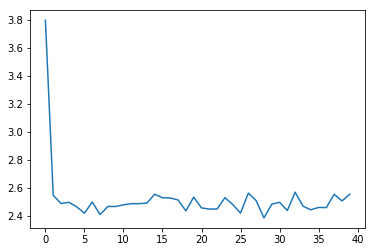

In [22]:
%matplotlib inline
plt.plot(losses)

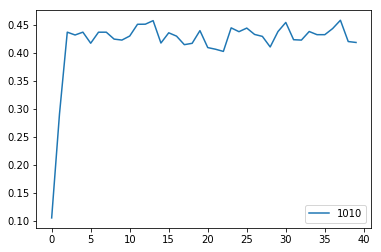

In [24]:
plt.plot(p10, label="1010")
plt.legend()

Look at the probability the trained state assigns to each z-basis state

In [25]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [29]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has probability 0.0055
tensor([1, 1, 1, 0]) has probability 0.0068
tensor([1, 1, 0, 1]) has probability 0.0058
tensor([1, 1, 0, 0]) has probability 0.0028
tensor([1, 0, 1, 1]) has probability 0.0061
tensor([1, 0, 1, 0]) has probability 0.4290
tensor([1, 0, 0, 1]) has probability 0.0420
tensor([1, 0, 0, 0]) has probability 0.0045
tensor([0, 1, 1, 1]) has probability 0.0039
tensor([0, 1, 1, 0]) has probability 0.0414
tensor([0, 1, 0, 1]) has probability 0.4264
tensor([0, 1, 0, 0]) has probability 0.0053
tensor([0, 0, 1, 1]) has probability 0.0035
tensor([0, 0, 1, 0]) has probability 0.0047
tensor([0, 0, 0, 1]) has probability 0.0065
tensor([0, 0, 0, 0]) has probability 0.0058


In [33]:
theta = torch.tensor([[np.pi/2]*L])
phi = torch.zeros_like(theta)
U = pauli_exp(theta, phi)

with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i],rotation=U).item()))

tensor([1, 1, 1, 1]) has probability 0.1056
tensor([1, 1, 1, 0]) has probability 0.0213
tensor([1, 1, 0, 1]) has probability 0.0306
tensor([1, 1, 0, 0]) has probability 0.1149
tensor([1, 0, 1, 1]) has probability 0.0145
tensor([1, 0, 1, 0]) has probability 0.1074
tensor([1, 0, 0, 1]) has probability 0.1080
tensor([1, 0, 0, 0]) has probability 0.0169
tensor([0, 1, 1, 1]) has probability 0.0261
tensor([0, 1, 1, 0]) has probability 0.0999
tensor([0, 1, 0, 1]) has probability 0.0920
tensor([0, 1, 0, 0]) has probability 0.0119
tensor([0, 0, 1, 1]) has probability 0.1059
tensor([0, 0, 1, 0]) has probability 0.0234
tensor([0, 0, 0, 1]) has probability 0.0209
tensor([0, 0, 0, 0]) has probability 0.1006
